In [1]:
import pandas as pd
import numpy as np
import joblib # For saving the model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    precision_recall_curve,
    f1_score
)

# --- Import Ensemble Tools ---
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression 

# --- Import Base Models ---
import xgboost as xgb
import lightgbm as lgb


In [2]:

# --- 1. Load Data ---
print("Loading train.csv...")
try:
    df = pd.read_csv('train.csv')
except FileNotFoundError:
    print("Error: train.csv not found.")
    exit()
else:
    print("Data loaded successfully.")


Loading train.csv...
Data loaded successfully.


In [3]:

# --- 2. Basic Cleaning & Define X/y ---
print("Cleaning data and defining features (X) and target (y)...")

cols_to_drop = ['Unnamed: 0', 'company_name', 'fyear']
cols_to_drop_existing = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=cols_to_drop_existing)

df = df.dropna(subset=['status_label'])

target = 'status_label'
y = df[target].map({'alive': 0, 'failed': 1})
X = df.drop(columns=[target])


Cleaning data and defining features (X) and target (y)...


In [4]:

# --- 3. Split Data into Training and Validation Sets ---
print("Splitting data into 80% train and 20% validation sets...")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y 
)


Splitting data into 80% train and 20% validation sets...


In [5]:

# --- 4. Define Preprocessing Pipelines ---
print("Defining preprocessing pipelines...")

numerical_features = [f'X{i}' for i in range(1, 19)]
categorical_features = ['Division', 'MajorGroup']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


Defining preprocessing pipelines...


In [6]:

# --- 5. Calculate scale_pos_weight for XGBoost ---
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\nCalculated scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")

# -----------------------------------------------------------------
# --- 6. Define the Champion Stacking Classifier Pipeline ---
# -----------------------------------------------------------------

print("\nDefining Champion Stacking Classifier pipeline...")

# --- Define our best models with their optimal parameters ---

best_model_xgb = xgb.XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight, # <-- Internal imbalance handling
    learning_rate=0.1,
    max_depth=10,
    min_child_weight=5,
    n_estimators=300,
    n_jobs=-1,
    eval_metric='logloss'
)

best_model_lgb = lgb.LGBMClassifier(
    random_state=42,
    class_weight='balanced', # <-- Internal imbalance handling
    learning_rate=0.1,
    min_child_samples=10,
    n_estimators=300,
    num_leaves=70,
    n_jobs=-1,
    verbose=-1
)

# --- Create the list of base estimators ---
estimators = [
    ('xgb', best_model_xgb),
    ('lgbm', best_model_lgb)
]

# --- Create the Stacking Classifier ---
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3, # Cross-validation for training the meta-model
    n_jobs=-1
)

# --- Create the FULL pipeline (Preprocessor + Stacker) ---
champion_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacker', stacking_model)
])



Calculated scale_pos_weight for XGBoost: 13.94

Defining Champion Stacking Classifier pipeline...


In [7]:
# --- 7. Train the Champion Classifier ---

print("\n--- Training Champion Stacking Classifier ---")
champion_pipeline.fit(X_train, y_train)
print("Training complete.")



--- Training Champion Stacking Classifier ---
Training complete.


In [8]:

# --- 8. Evaluate and Apply Optimal Threshold ---

print("\n--- Applying Optimal Threshold Tuning to Champion Model ---")

# Get probabilities for the positive class
y_pred_proba = champion_pipeline.predict_proba(X_val)[:, 1]

# Calculate F1-score for all thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)

# Find the best threshold
best_f1_idx = np.argmax(f1_scores[:-1])
best_threshold = thresholds[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]

print(f"Best F1-Score found: {best_f1:.4f}")
print(f"Optimal Threshold: {best_threshold:.4f}")

# --- Evaluate with the NEW threshold ---
print("\n--- Final Model Evaluation (Champion + Optimal Threshold) ---")

y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)

print(f"Accuracy: {accuracy_score(y_val, y_pred_optimal):.4f}")
print("--------------------------------------------------")
print("ROC-AUC Score: "
      f"{roc_auc_score(y_val, y_pred_proba):.4f}")
print("--------------------------------------------------")
print("Confusion Matrix (Optimal Threshold):")
print(confusion_matrix(y_val, y_pred_optimal))
print("--------------------------------------------------")
print("Classification Report (Optimal Threshold):")
print(classification_report(y_val, y_pred_optimal, target_names=['alive (0)', 'failed (1)']))
print("--------------------------------------------------")





--- Applying Optimal Threshold Tuning to Champion Model ---
Best F1-Score found: 0.4501
Optimal Threshold: 0.2858

--- Final Model Evaluation (Champion + Optimal Threshold) ---
Accuracy: 0.9245
--------------------------------------------------
ROC-AUC Score: 0.8683
--------------------------------------------------
Confusion Matrix (Optimal Threshold):
[[11222   495]
 [  453   388]]
--------------------------------------------------
Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

   alive (0)       0.96      0.96      0.96     11717
  failed (1)       0.44      0.46      0.45       841

    accuracy                           0.92     12558
   macro avg       0.70      0.71      0.70     12558
weighted avg       0.93      0.92      0.93     12558

--------------------------------------------------


c:\Users\sreeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [9]:
# --- 9. Save the Final Model ---

print("\n--- Saving the final pipeline... ---")
# We save the 'champion_pipeline' object. 
# The threshold (0.2858) must be saved and applied separately.
joblib.dump(champion_pipeline, 'champion_model.joblib')

print(f"\n✅ Champion model saved to 'champion_model.joblib'")
print(f"Remember to use threshold = {best_threshold:.4f} for predictions.")


--- Saving the final pipeline... ---

✅ Champion model saved to 'champion_model.joblib'
Remember to use threshold = 0.2858 for predictions.


In [11]:
import pandas as pd
import joblib
import numpy as np

# --- 1. Define File Names and Threshold ---
MODEL_FILE = 'champion_model.joblib'
TEST_FILE = 'test.csv'
OUTPUT_FILE = 'output.csv'

# This is the optimal threshold found for our champion model
# (the XGB+LGBM stack that gave F1=0.45)
OPTIMAL_THRESHOLD = 0.2858 

print("Loading model and test data...")

# --- 2. Load Model and Test Data ---
try:
    # Load the trained pipeline
    pipeline = joblib.load(MODEL_FILE)
    
    # Load the new test data
    df_test = pd.read_csv(TEST_FILE)
    
    # Keep a copy of the company names for the output file
    if 'company_name' in df_test.columns:
        company_names = df_test['company_name']
    else:
        print("Warning: 'company_name' column not found in test.csv. Using index as fallback.")
        company_names = df_test.index
        
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please make sure 'champion_model.joblib' and 'test.csv' are in the same directory.")
else:
    print("Model and data loaded successfully.")

    # --- 3. Generate Predictions ---
    print("Generating predictions...")
    
    # Use predict_proba to get probabilities for the 'failed' class (class 1)
    # The pipeline handles all preprocessing internally
    y_pred_proba_test = pipeline.predict_proba(df_test)[:, 1]

    # Apply the optimal threshold to get final 0 or 1 predictions
    y_pred_final = (y_pred_proba_test >= OPTIMAL_THRESHOLD).astype(int)
    
    # Map predictions back to the status labels
    # 0 = alive, 1 = failed
    y_pred_status = np.where(y_pred_final == 1, 'failed', 'alive')

    print("Predictions generated.")

    # --- 4. Create and Save Output File ---
    
    # Create a DataFrame with the company name and predicted status
    df_output = pd.DataFrame({
        'company_name': company_names,
        'status': y_pred_status
    })

    # Save to CSV
    df_output.to_csv(OUTPUT_FILE, index=False)

    print(f"\n✅ Success! Predictions saved to '{OUTPUT_FILE}'")
    print("\nOutput file head:")
    print(df_output.head())

Loading model and test data...
Model and data loaded successfully.
Generating predictions...
Predictions generated.

✅ Success! Predictions saved to 'output.csv'

Output file head:
  company_name status
0          C_3  alive
1          C_3  alive
2          C_3  alive
3          C_3  alive
4          C_3  alive


c:\Users\sreeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


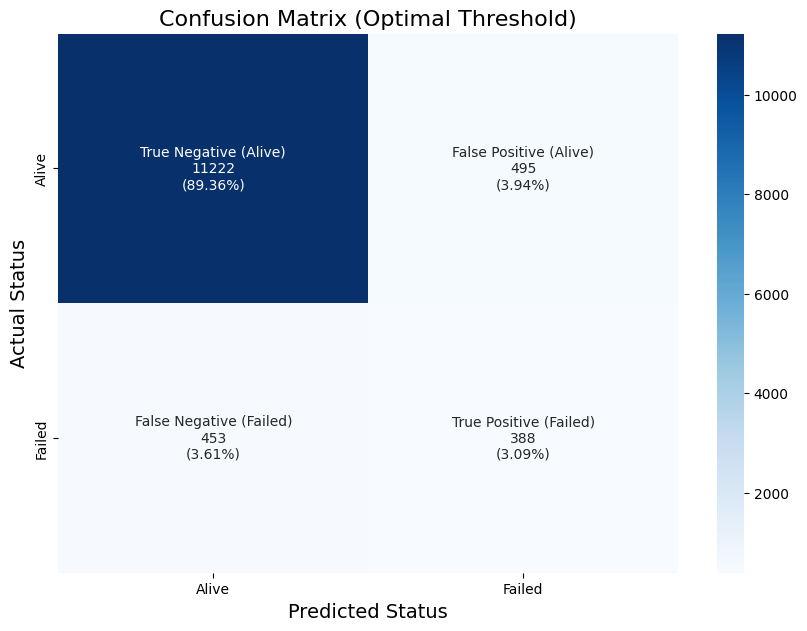

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred_optimal)

# 2. Define labels for the plot
labels = ['True Negative (Alive)', 'False Positive (Alive)',
          'False Negative (Failed)', 'True Positive (Failed)']
categories = ['Alive', 'Failed']
count_values = [f'{value}' for value in cm.flatten()]
percent_values = [f'{value/np.sum(cm)*100:.2f}%' for value in cm.flatten()]
box_labels = [f'{v1}\n{v2}\n({v3})' for v1, v2, v3 in zip(labels, count_values, percent_values)]
box_labels = np.asarray(box_labels).reshape(2, 2)

# 3. Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=box_labels, fmt='', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Status', fontsize=14)
plt.ylabel('Actual Status', fontsize=14)
plt.title('Confusion Matrix (Optimal Threshold)', fontsize=16)
plt.show()

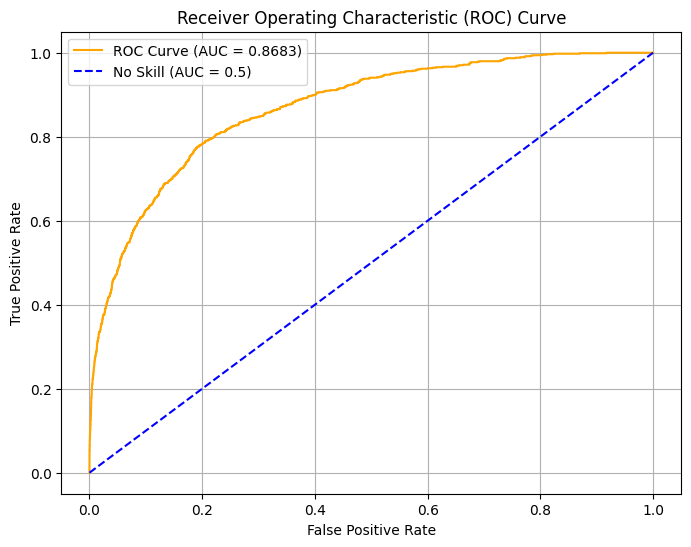

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# 2. Calculate AUC
auc_score = roc_auc_score(y_val, y_pred_proba)

# 3. Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='No Skill (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

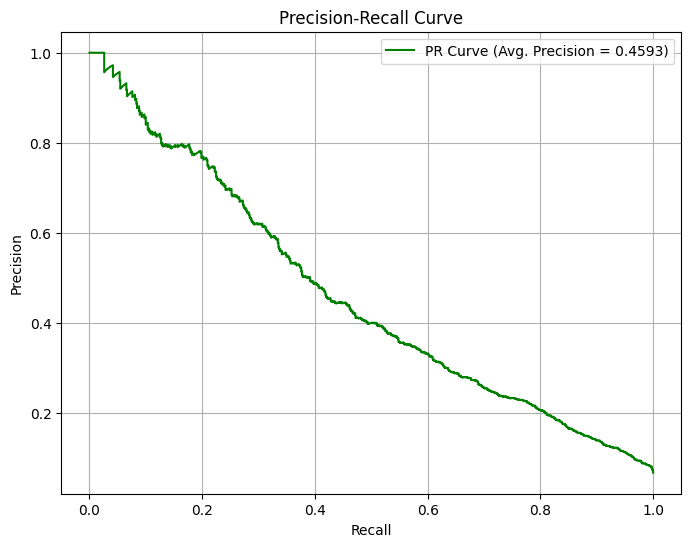

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1. Calculate Precision-Recall curve points
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# 2. Calculate Average Precision
avg_precision = average_precision_score(y_val, y_pred_proba)

# 3. Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'PR Curve (Avg. Precision = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

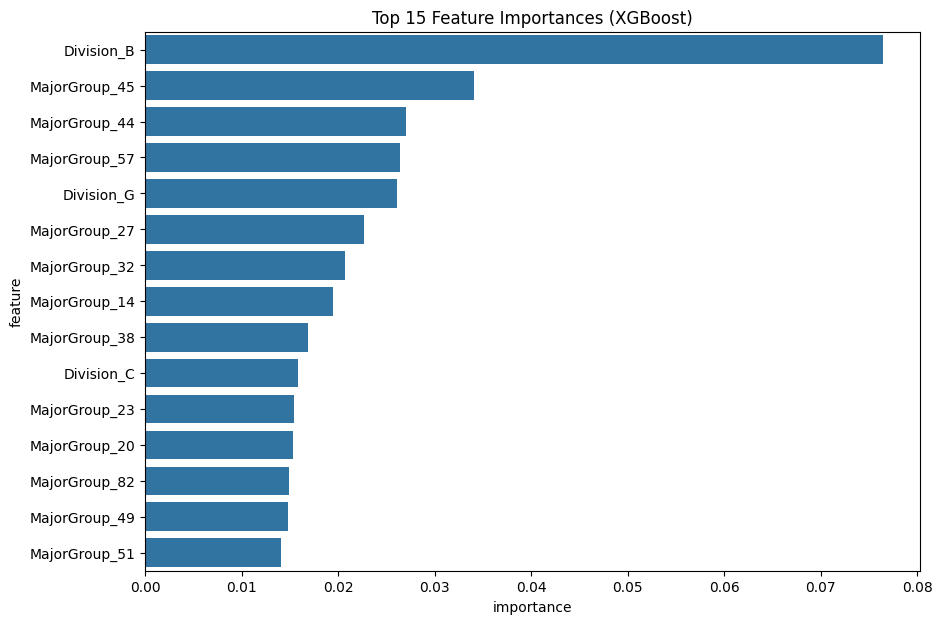

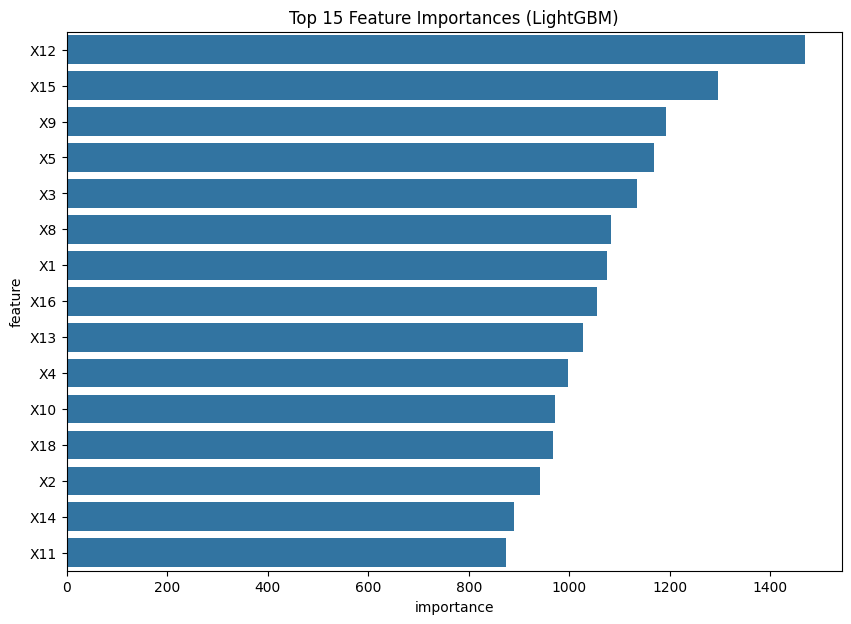

In [16]:
try:
    # 1. Get the list of final feature names from the preprocessor
    preprocessor = champion_pipeline.named_steps['preprocessor']
    
    # Get numerical feature names (they are unchanged)
    num_features = preprocessor.transformers_[0][2]
    
    # Get categorical feature names from the OneHotEncoder
    ohe_categories = preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_
    cat_features = [f'{col}_{cat}' for i, col in enumerate(categorical_features) for cat in ohe_categories[i]]
    
    # Combine all feature names
    all_feature_names = num_features + cat_features

    # 2. Get the fitted stacker model
    stacker = champion_pipeline.named_steps['stacker']

    # 3. Get the fitted base models (XGB and LGBM)
    xgb_model_fitted = stacker.named_estimators_['xgb']
    lgbm_model_fitted = stacker.named_estimators_['lgbm']

    # 4. Get importances
    xgb_importances = xgb_model_fitted.feature_importances_
    lgbm_importances = lgbm_model_fitted.feature_importances_

    # --- Plot XGBoost Importances ---
    xgb_feat_df = pd.DataFrame({'feature': all_feature_names, 'importance': xgb_importances})
    xgb_feat_df = xgb_feat_df.sort_values(by='importance', ascending=False).head(15) # Top 15

    plt.figure(figsize=(10, 7))
    sns.barplot(x='importance', y='feature', data=xgb_feat_df)
    plt.title('Top 15 Feature Importances (XGBoost)')
    plt.show()

    # --- Plot LightGBM Importances ---
    lgbm_feat_df = pd.DataFrame({'feature': all_feature_names, 'importance': lgbm_importances})
    lgbm_feat_df = lgbm_feat_df.sort_values(by='importance', ascending=False).head(15) # Top 15
    
    plt.figure(figsize=(10, 7))
    sns.barplot(x='importance', y='feature', data=lgbm_feat_df)
    plt.title('Top 15 Feature Importances (LightGBM)')
    plt.show()

except Exception as e:
    print(f"Error extracting feature importances: {e}")
    print("This can happen if the model structure is different than expected.")

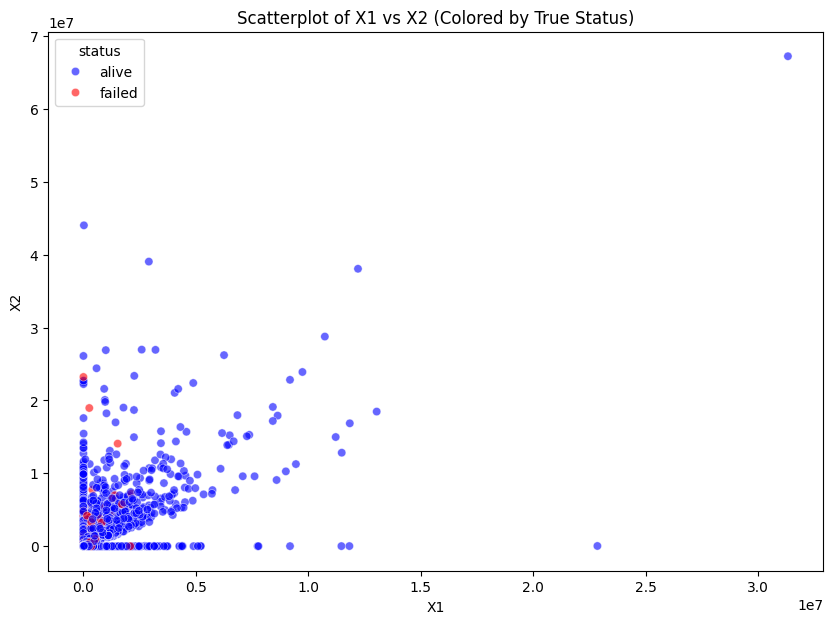

In [17]:
# 1. We need the original X_val (a DataFrame) and y_val (a Series)
# We merge them to make plotting with seaborn easy
plot_df = X_val.copy()
plot_df['status'] = y_val.map({0: 'alive', 1: 'failed'}) # Use original y_val

# 2. Create the scatterplot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=plot_df, 
    x='X1', 
    y='X2', 
    hue='status', 
    palette={'alive': 'blue', 'failed': 'red'},
    alpha=0.6
)
plt.title('Scatterplot of X1 vs X2 (Colored by True Status)')
plt.show()